### 0. 라이브러리 임포트

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

tqdm.pandas()

### 1. 데이터 불러오기

In [129]:
with open('../data/train.csv') as f:
    train = pd.read_csv(f)
with open('../data/test.csv') as f:
    test = pd.read_csv(f)

/tmp/ipykernel_625408/287244562.py:2: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f)


한번에 전처리하기 위해 train, test를 묶음

In [130]:
test['target'] = 0
train['is_test'] = 0
test['is_test'] = 1
train = pd.concat([train, test])

In [131]:
train.reset_index(inplace = True)
train.drop(columns = 'index', inplace = True)

columns 이름을 보기 편하게 변경

In [132]:
train.columns = [col.replace('㎡', 'm').replace('k-','').replace('기타/의무/임대/임의=1/2/3/4','기타의무임대임의').replace('(아파트,주상복합등등)','').replace('(','_').replace(')','') for col in train.columns]


x, y 데이터 추가

In [133]:
with open('../data/include_xy.csv') as f:
    xydata = pd.read_csv(f)

In [134]:
train['addr'] = train['시군구'] + ' ' + train['번지']

In [135]:
train = pd.merge(train, xydata, how = 'left', left_on = 'addr', right_on = 'addr')
train.drop(columns = ['좌표X','좌표Y'], inplace = True)
train.head(5)

시군구     번지     본번   부번    아파트명  전용면적_m    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97  201712    8  3  1987   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97  201712   22  4  1987   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   54.98  201712   28  5  1987   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97  201801    3  4  1987   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97  201801    8  2  1987   

   ... 기타의무임대임의                  단지승인일 사용허가여부 관리비 업로드                  단지신청일  \
0  ...       임의  2022-11-17 13:00:29.0      Y       N  2022-11-17 10:19:06.0   
1  ...       임의  2022-11-17 13:00:29.0      Y       N  2022-11-17 10:19:06.0   
2  ...       임의  2022-11-17 13:00:29.0      Y       N  2022-11-17 10:19:06.0   
3  ...       임의  2022-11-17 13:00:29.0      Y       N  2022-11-17 10:19:06.0   
4  ...       임의  2022-11-17 13:00:29.0      Y       N  2022-11-17 10:19:06.0   

   target is_test                 addr           x          y  
0  124000       0  서울특별시 강남구 개포동 658-1  127.057212  37.476156  
1  123500       0  서울특별시 강남구 개포동 658-1  127.057212  37.476156  
2   91500       0  서울특별시 강남구 개포동 658-1  127.057212  37.476156  
3  130000       0  서울특별시 강남구 개포동 658-1  127.057212  37.476156  
4  117000       0  서울특별시 강남구 개포동 658-1  127.057212  37.476156  

[5 rows x 54 columns]

In [136]:
train.to_csv('../data/processed_df.csv', index = False)

### 2. EDA

#### 결측비율 확인

결측치 표현을 실제 결측치로 변경

In [137]:
train['거래유형'] = train['거래유형'].replace('-', np.nan)
train['등기신청일자'] = train['등기신청일자'].replace(' ', np.nan)
train['중개사소재지'] = train['중개사소재지'].replace('-', np.nan)

그래프로 그려보기

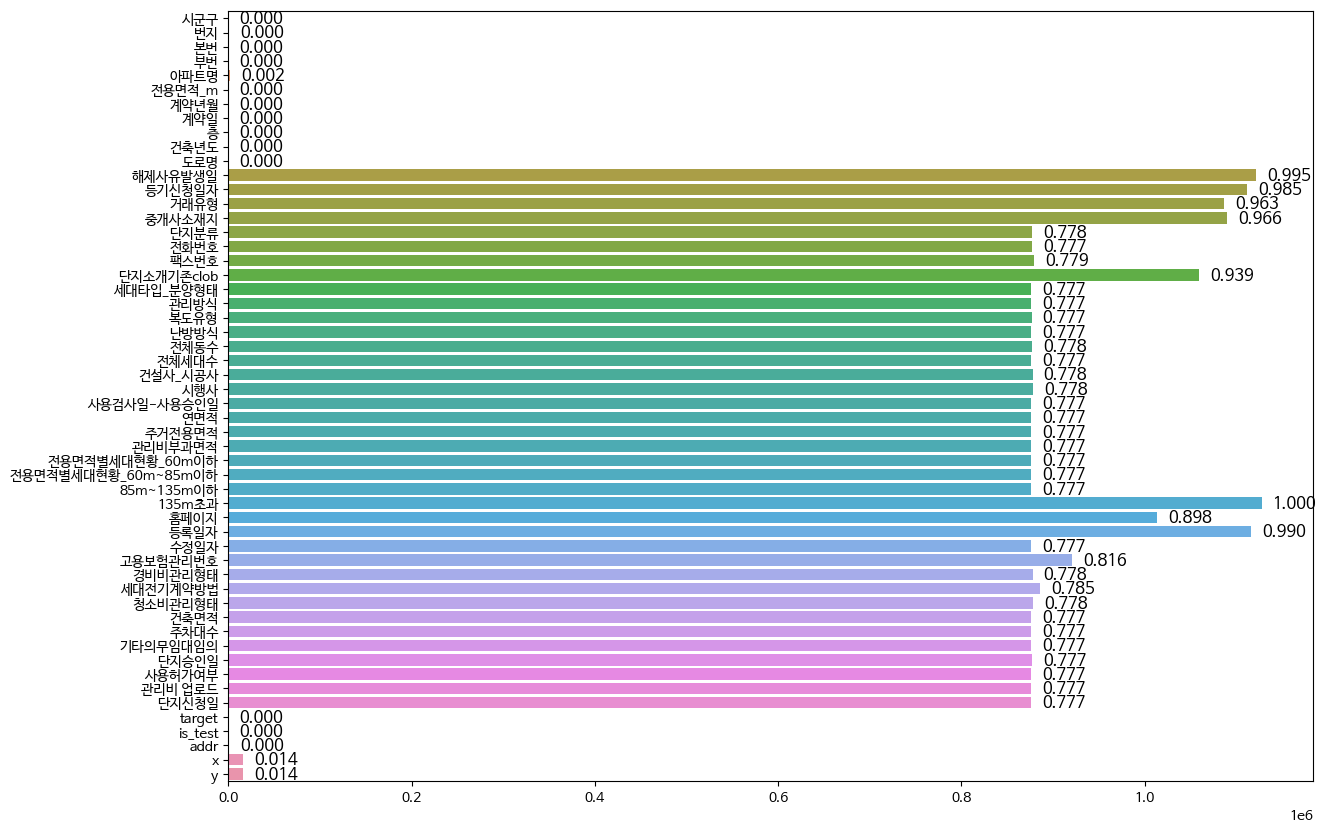

In [138]:
missingnum = []
for i, v in enumerate(train.columns):
    missingnum.append(train[v].isnull().sum())

plt.figure(figsize = (14,10))
plots = sns.barplot(x = missingnum, y = train.columns)
for bar in plots.patches:
      plots.annotate(format(bar.get_width() / len(train), '.3f'), 
                   (bar.get_width(), bar.get_y() + bar.get_height()/2),
                    ha='left', va='center',
                   size=12, xytext=(8, 0),
                   textcoords='offset points')
plt.show()

비교적 많은 feature가 77%이상의 결측비율을 가지는 것을 확인할 수 있음

#### 상관관계 확인

계약년월을 계약년, 계약월로 나누어서 상관관계 확인

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


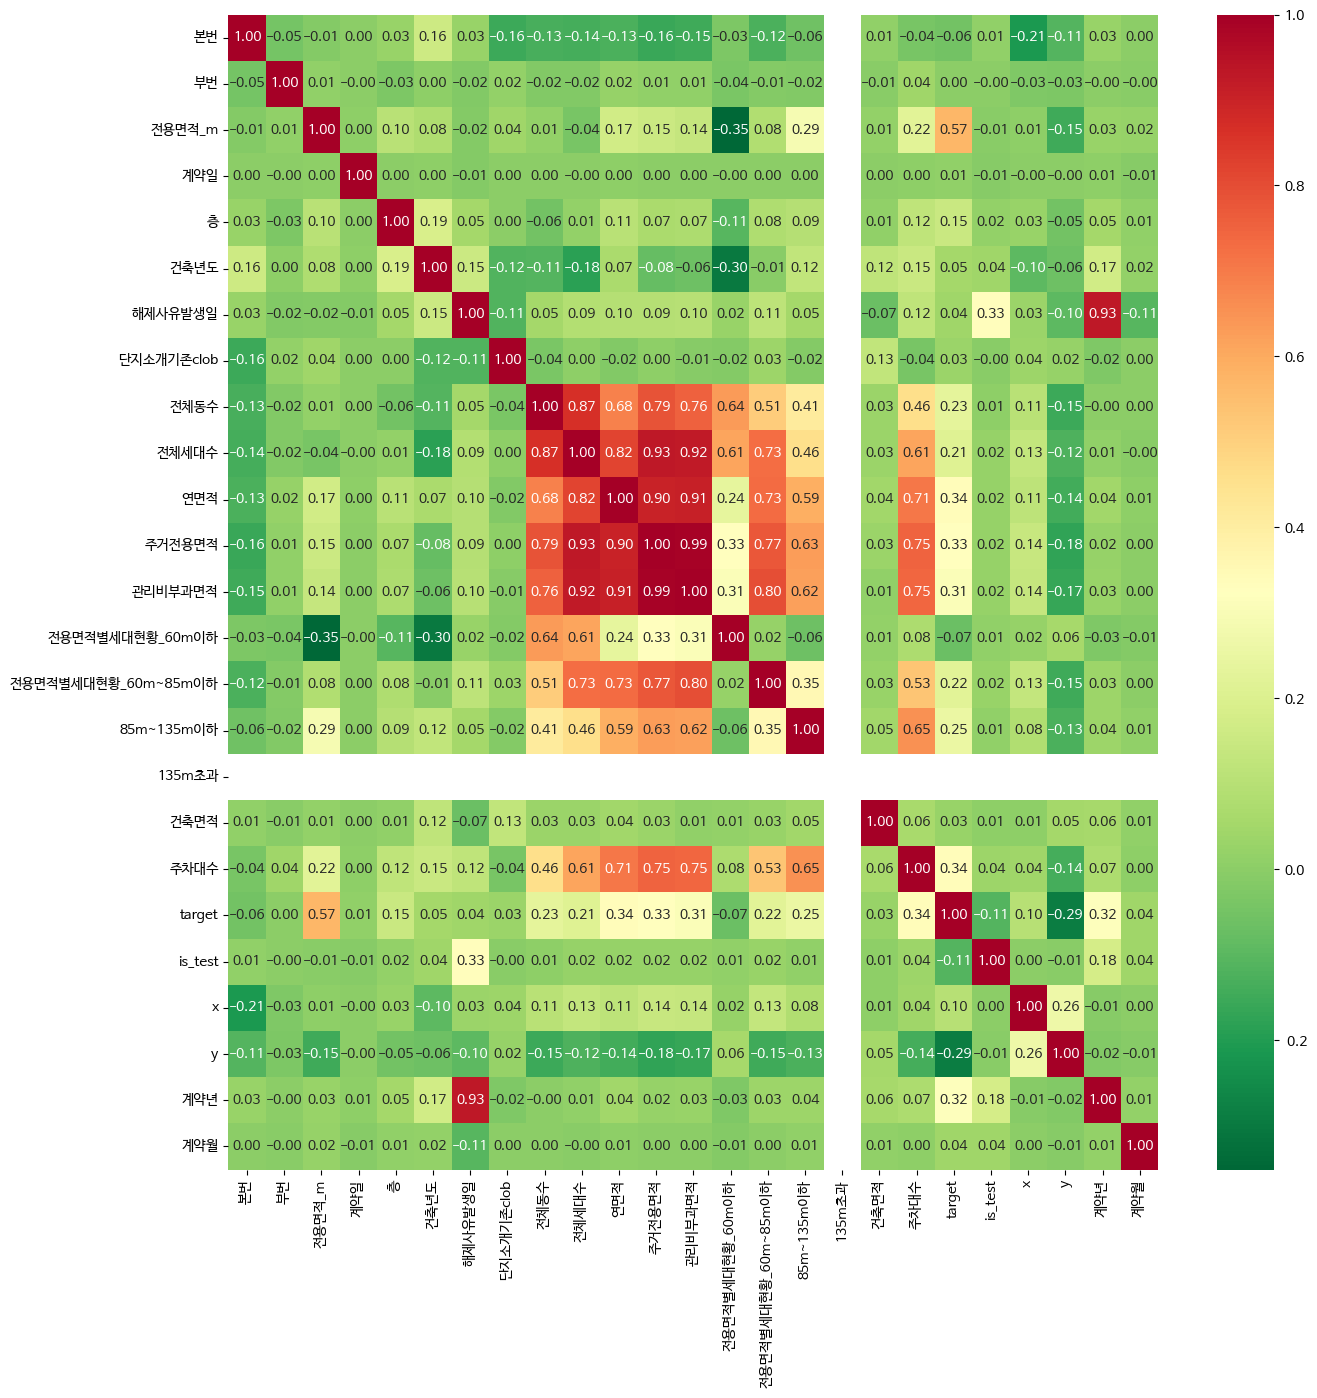

In [139]:
def year_month_parser(x):
    year = int(str(x)[0:4])
    month = int(str(x)[4:6])
    return [year, month]

train['계약년'] = train['계약년월'].apply(lambda x : year_month_parser(x)[0])
train['계약월'] = train['계약년월'].apply(lambda x : year_month_parser(x)[1])
train.drop(columns = '계약년월', inplace = True)
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(numeric_only=True), annot = True, fmt = '.2f', cmap='RdYlGn_r')

1. '135m초과'는 어떠한 column과도 상관관계가 존재하지 않는다.
2. 아파트의 크기와 관련된 feature들은 서로 강한 상관관계가 있다.<br>
$\rightarrow$'전체 동수','전체 세대수','연면적','주거전용면적','관리비부과면적','전용면적별세대현황','주차면적'
3. target과 강한 상관관계가 있는 feature는 '전용면적_m','좌표Y','계약년'와 면적관련 3가지 feature ('연면적','주거전용면적','관리비부과면적')이다.

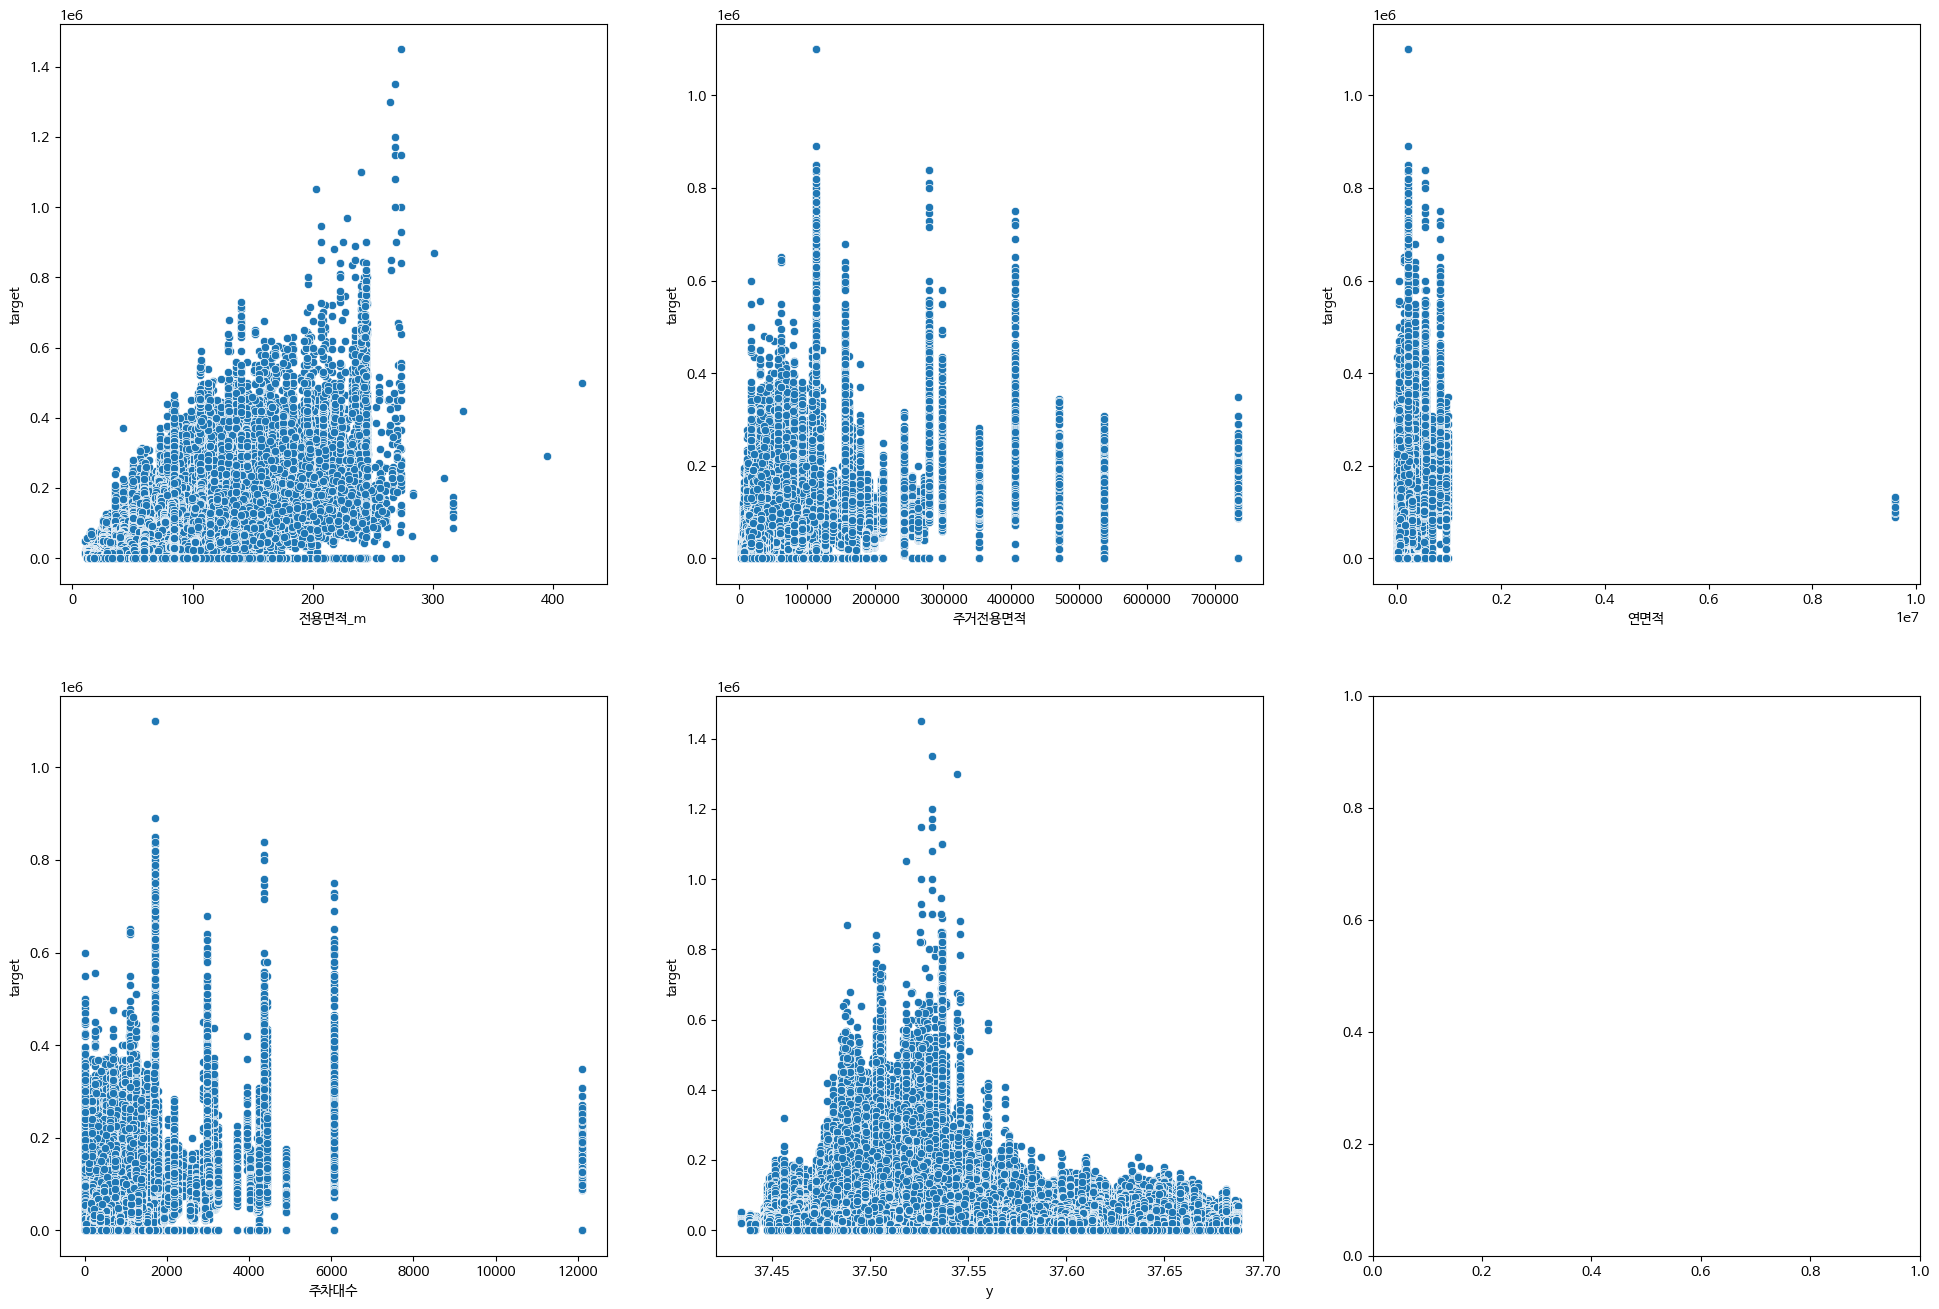

In [140]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 16))
for i, v in enumerate(['전용면적_m','주거전용면적','연면적','주차대수','y']):
    sns.scatterplot(data = train, x = v, y = 'target', ax = ax[i//3][i%3])

1. 연면적의 경우, outlier가 있어 이를 처리하고도 상관관계가 있는지 확인해볼 필요가 있음
2. 좌표Y의 경우, 특정 좌표에서 값이 크게 오르는 것을 확인할 수 있음
3. '좌표Y','연면적','주거전용면적','관리비부과면적' 은 결측치가 높아 이를 보간할 방법이 필요 or 아예 drop<br><br>
면적의 경우, 아예 보간을 할 방법이 마땅치 않음 $\rightarrow$ **drop**<br>
관리비도 어렵다는 판단으로 drop

### 3. feature engineering

In [141]:
df = train.drop(columns = ['전화번호','팩스번호'])
df.reset_index(inplace=True)
df.head(5)

index            시군구     번지     본번   부번    아파트명  전용면적_m  계약일  층  건축년도  ...  \
0      0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97    8  3  1987  ...   
1      1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97   22  4  1987  ...   
2      2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   54.98   28  5  1987  ...   
3      3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97    3  4  1987  ...   
4      4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성   79.97    8  2  1987  ...   

  사용허가여부  관리비 업로드                  단지신청일  target is_test                 addr  \
0      Y        N  2022-11-17 10:19:06.0  124000       0  서울특별시 강남구 개포동 658-1   
1      Y        N  2022-11-17 10:19:06.0  123500       0  서울특별시 강남구 개포동 658-1   
2      Y        N  2022-11-17 10:19:06.0   91500       0  서울특별시 강남구 개포동 658-1   
3      Y        N  2022-11-17 10:19:06.0  130000       0  서울특별시 강남구 개포동 658-1   
4      Y        N  2022-11-17 10:19:06.0  117000       0  서울특별시 강남구 개포동 658-1   

            x          y   계약년 계약월  
0  127.057212  37.476156  2017  12  
1  127.057212  37.476156  2017  12  
2  127.057212  37.476156  2017  12  
3  127.057212  37.476156  2018   1  
4  127.057212  37.476156  2018   1  

[5 rows x 54 columns]

In [142]:
df.columns

Index(['index', '시군구', '번지', '본번', '부번', '아파트명', '전용면적_m', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지분류', '단지소개기존clob',
       '세대타입_분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사_시공사', '시행사',
       '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황_60m이하',
       '전용면적별세대현황_60m~85m이하', '85m~135m이하', '135m초과', '홈페이지', '등록일자', '수정일자',
       '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타의무임대임의', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'target', 'is_test',
       'addr', 'x', 'y', '계약년', '계약월'],
      dtype='object')

#### 기준 금리 데이터 추가

In [143]:
with open('../data/interest_rate.csv') as f:
    interest = pd.read_csv(f)

#출처 : https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643

In [144]:
t = interest
t = t.astype('str')
interest.loc[:,'datetime'] = t['year'] + t['month'].apply(lambda x: '0'+x if len(x) == 1 else x) + t['date'].apply(lambda x: '0'+x if len(x) == 1 else x)
interest.sort_values(by = ['year','month','date'], ascending=True, inplace = True)
interest.reset_index(inplace=True)
interest.drop(columns = 'index', inplace = True)


In [145]:
# import datetime
# df['interest_rate'] = [-1] * len(df)
# for i in range(len(df)):
#     contract_date = str(df.loc[i,'계약년']) + '-' + str(df.loc[i, '계약월'])+ '-'+ str(df.loc[i,'계약일'])
#     contract_date = datetime.datetime.strptime(contract_date, '%Y-%m-%d')
#     for j in range(len(interest)-1):
#         compare_date1 = datetime.datetime.strptime(interest.loc[j,'datetime'], '%Y%m%d')
#         compare_date2 = datetime.datetime.strptime(interest.loc[j+1,'datetime'], '%Y%m%d')
#         if (compare_date1<=contract_date) and (contract_date < compare_date2):
#             df.loc[i, 'interest_rate'] =  interest.loc[j, 'rate']
#             break


In [146]:
# df.loc[:,'interest_rate'] = df['interest_rate'].apply(lambda x : 3.5 if x == -1 else x)

In [147]:
df.to_csv('../data/dataframe.csv', index = False)

In [148]:
with open('../data/dataframe.csv') as f:
    df = pd.read_csv(f)

/tmp/ipykernel_625408/2153709074.py:2: DtypeWarning: Columns (13,14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


큰 상관관계가 없던 계약 월, 계약 일 삭제

In [149]:
# df.drop(columns=['계약월','계약일', 'index'], inplace = True)
# df.head(5)

#### 강남여부 확인

In [150]:
def gangnam_parser(x):
    gu_li = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
    if x.split(' ')[1] in gu_li:
        return 1
    else:
        return 0

df.loc[:,'is_gangnam'] = df['시군구'].apply(gangnam_parser)

In [151]:
df.drop(columns = ['시군구','아파트명'], inplace = True)

#### 역세권 찾기

In [152]:
# with open('../data/subway_feature.csv') as f:
#     subway_df = pd.read_csv(f)

# def subway_distance(x, y):
#     y_building = y
#     x_building = x
#     for i in range(len(subway_df)):
#         x_subway = subway_df.loc[i, '경도']
#         y_subway = subway_df.loc[i, '위도']

#         x_distance = abs(x_building - x_subway)
#         y_distance = abs(y_building - y_subway)

#         #위도 경도 변환
#         x_distance = 88000 * x_distance
#         y_distance = 110000 * y_distance

#         distance = np.sqrt(x_distance ** 2 + y_distance ** 2)
#         if distance <= 500:
#             return 1

#     return 0

# tmp = train.progress_apply(lambda row : subway_distance(row['x'], row['y']), axis = 1)

In [153]:
# tmp.to_csv('../data/is_subway.csv', index = False)

In [154]:
with open('../data/is_subway.csv') as f:
    tmp = pd.read_csv(f)

df['is_subway'] = tmp

#### target을 평균을 이용해서 처리

In [155]:
df

index     번지     본번   부번  전용면적_m  계약일   층  건축년도        도로명  \
0              0  658-1  658.0  1.0   79.97    8   3  1987      언주로 3   
1              1  658-1  658.0  1.0   79.97   22   4  1987      언주로 3   
2              2  658-1  658.0  1.0   54.98   28   5  1987      언주로 3   
3              3  658-1  658.0  1.0   79.97    3   4  1987      언주로 3   
4              4  658-1  658.0  1.0   79.97    8   2  1987      언주로 3   
...          ...    ...    ...  ...     ...  ...  ..   ...        ...   
1128089  1128089    816  816.0  0.0   84.65   19  13  2014  신내역로1길 85   
1128090  1128090    816  816.0  0.0   84.62   25  12  2014  신내역로1길 85   
1128091  1128091    816  816.0  0.0  101.65   27  12  2014  신내역로1길 85   
1128092  1128092    816  816.0  0.0   84.94    2  18  2014  신내역로1길 85   
1128093  1128093    816  816.0  0.0   84.65    4  13  2014  신내역로1길 85   

            해제사유발생일  ...                  단지신청일  target is_test  \
0               NaN  ...  2022-11-17 10:19:06.0  124000       0   
1               NaN  ...  2022-11-17 10:19:06.0  123500       0   
2               NaN  ...  2022-11-17 10:19:06.0   91500       0   
3               NaN  ...  2022-11-17 10:19:06.0  130000       0   
4               NaN  ...  2022-11-17 10:19:06.0  117000       0   
...             ...  ...                    ...     ...     ...   
1128089  20230801.0  ...  2014-09-01 13:05:03.0       0       1   
1128090         NaN  ...  2014-09-01 13:05:03.0       0       1   
1128091         NaN  ...  2014-09-01 13:05:03.0       0       1   
1128092         NaN  ...  2014-09-01 13:05:03.0       0       1   
1128093         NaN  ...  2014-09-01 13:05:03.0       0       1   

                        addr           x          y   계약년 계약월 is_gangnam  \
0        서울특별시 강남구 개포동 658-1  127.057212  37.476156  2017  12          1   
1        서울특별시 강남구 개포동 658-1  127.057212  37.476156  2017  12          1   
2        서울특별시 강남구 개포동 658-1  127.057212  37.476156  2017  12          1   
3        서울특별시 강남구 개포동 658-1  127.057212  37.476156  2018   1          1   
4        서울특별시 강남구 개포동 658-1  127.057212  37.476156  2018   1          1   
...                      ...         ...        ...   ...  ..        ...   
1128089    서울특별시 중랑구 신내동 816  127.106824  37.617373  2023   7          0   
1128090    서울특별시 중랑구 신내동 816  127.106824  37.617373  2023   7          0   
1128091    서울특별시 중랑구 신내동 816  127.106824  37.617373  2023   8          0   
1128092    서울특별시 중랑구 신내동 816  127.106824  37.617373  2023   9          0   
1128093    서울특별시 중랑구 신내동 816  127.106824  37.617373  2023   9          0   

         is_subway  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
1128089          0  
1128090          0  
1128091          0  
1128092          0  
1128093          0  

[1128094 rows x 54 columns]

In [156]:
df['price'] = df[df['is_test'] == 0].groupby(['도로명'])['target'].transform('mean')


#### 최근 5년 데이터만 사용

In [157]:
# df = df[df['계약년'] >= 2022]

### label encoding

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 55 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   index                1128094 non-null  int64  
 1   번지                   1127867 non-null  object 
 2   본번                   1128019 non-null  float64
 3   부번                   1128019 non-null  float64
 4   전용면적_m               1128094 non-null  float64
 5   계약일                  1128094 non-null  int64  
 6   층                    1128094 non-null  int64  
 7   건축년도                 1128094 non-null  int64  
 8   도로명                  1128094 non-null  object 
 9   해제사유발생일              6195 non-null     float64
 10  등기신청일자               16823 non-null    float64
 11  거래유형                 41643 non-null    object 
 12  중개사소재지               38081 non-null    object 
 13  단지분류                 250821 non-null   object 
 14  단지소개기존clob           69136 non-null    float64
 15

In [159]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for v in df.columns:
    if pd.api.types.is_object_dtype(df[v]):
        print(v)
        df[v] = encoder.fit_transform(df[v])
df

번지
도로명
거래유형
중개사소재지
단지분류
세대타입_분양형태
관리방식
복도유형
난방방식
건설사_시공사
시행사
사용검사일-사용승인일
홈페이지
등록일자
수정일자
고용보험관리번호
경비비관리형태
세대전기계약방법
청소비관리형태
기타의무임대임의
단지승인일
사용허가여부
관리비 업로드
단지신청일
addr


index    번지     본번   부번  전용면적_m  계약일   층  건축년도   도로명     해제사유발생일  \
0              0  4737  658.0  1.0   79.97    8   3  1987  6185         NaN   
1              1  4737  658.0  1.0   79.97   22   4  1987  6185         NaN   
2              2  4737  658.0  1.0   54.98   28   5  1987  6185         NaN   
3              3  4737  658.0  1.0   79.97    3   4  1987  6185         NaN   
4              4  4737  658.0  1.0   79.97    8   2  1987  6185         NaN   
...          ...   ...    ...  ...     ...  ...  ..   ...   ...         ...   
1128089  1128089  5801  816.0  0.0   84.65   19  13  2014  5564  20230801.0   
1128090  1128090  5801  816.0  0.0   84.62   25  12  2014  5564         NaN   
1128091  1128091  5801  816.0  0.0  101.65   27  12  2014  5564         NaN   
1128092  1128092  5801  816.0  0.0   84.94    2  18  2014  5564         NaN   
1128093  1128093  5801  816.0  0.0   84.65    4  13  2014  5564         NaN   

         ...  target  is_test  addr           x          y   계약년  계약월  \
0        ...  124000        0    39  127.057212  37.476156  2017   12   
1        ...  123500        0    39  127.057212  37.476156  2017   12   
2        ...   91500        0    39  127.057212  37.476156  2017   12   
3        ...  130000        0    39  127.057212  37.476156  2018    1   
4        ...  117000        0    39  127.057212  37.476156  2018    1   
...      ...     ...      ...   ...         ...        ...   ...  ...   
1128089  ...       0        1  8923  127.106824  37.617373  2023    7   
1128090  ...       0        1  8923  127.106824  37.617373  2023    7   
1128091  ...       0        1  8923  127.106824  37.617373  2023    8   
1128092  ...       0        1  8923  127.106824  37.617373  2023    9   
1128093  ...       0        1  8923  127.106824  37.617373  2023    9   

         is_gangnam  is_subway          price  
0                 1          0  104403.465347  
1                 1          0  104403.465347  
2                 1          0  104403.465347  
3                 1          0  104403.465347  
4                 1          0  104403.465347  
...             ...        ...            ...  
1128089           0          0            NaN  
1128090           0          0            NaN  
1128091           0          0            NaN  
1128092           0          0            NaN  
1128093           0          0            NaN  

[1128094 rows x 55 columns]

### 3. Modeling

In [160]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from functools import partial
import optuna
from sklearn.metrics import mean_squared_error


In [164]:
train[train['계약년'] <= 2020].__len__()

1045943

In [166]:
test = df[df['is_test'] == 1]
test.drop(columns = ['target','is_test','price'], inplace = True)
train = df[df['is_test'] == 0]
train.drop(columns = 'is_test',inplace = True)

X_train = train[train['계약년'] <= 2020]
X_train = X_train.drop(columns=['target'])
y_train = X_train['price']
X_train = X_train.drop(columns=['price'])

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"test shape : {test.shape}")


/tmp/ipykernel_625408/751170959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns = ['target','is_test','price'], inplace = True)
/tmp/ipykernel_625408/751170959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns = 'is_test',inplace = True)


X_train shape : (1045943, 52)
y_train shape : (1045943,)
test shape : (9272, 52)


사용안하는 feature 제거

In [167]:
X_train = X_train[['전용면적_m','건축년도','y']]


In [168]:
test = test[['전용면적_m','건축년도','y']]

In [169]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1045943 entries, 0 to 1118821
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   전용면적_m  1045943 non-null  float64
 1   건축년도    1045943 non-null  int64  
 2   y       1030220 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 31.9 MB


In [170]:
model = XGBRegressor(max_depth = 5,
                     n_estimators = 200,
                     learning_rate = 0.01,
                     colsample_bytree = 0.75,
                     reg_lambda = 0.05,
                     random_state = 42)
    
kf = KFold(n_splits = 5, random_state=42, shuffle=True)
evaluation = []
for idx, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_train))):
    X_val = X_train.iloc[val_idx,:]
    X_training = X_train.iloc[train_idx,:]
    y_val = y_train.iloc[val_idx]
    y_training = y_train.iloc[train_idx]
  
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 42)


    model.fit(X_training, y_training)
    prediction = model.predict(X_val)
    evaluation.append(np.sqrt(mean_squared_error(y_val, prediction)))
print(evaluation)
np.mean(evaluation)

5it [00:06,  1.33s/it]

[23893.837953713053, 23464.42587209126, 23797.25621813995, 23734.97051968322, 23603.23818847043]


23698.745750419585

In [171]:
model.feature_names_in_

array(['전용면적_m', '건축년도', 'y'], dtype='<U6')

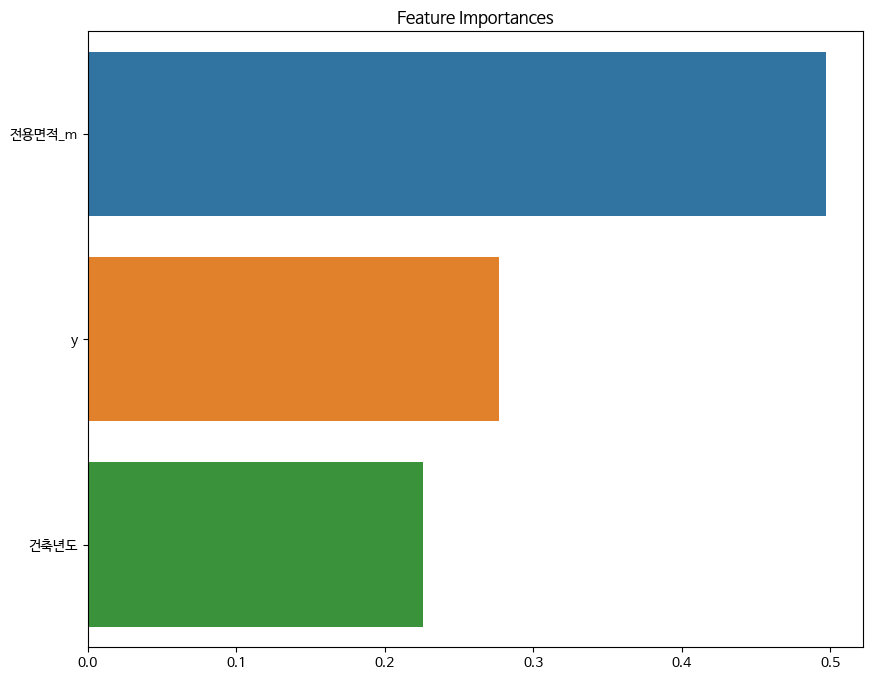

In [172]:
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [173]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

interpretmodel = ExplainableBoostingRegressor()
interpretmodel.fit(X_train, y_train)
from interpret import set_visualize_provider
from interpret.provider import InlineProvider


/opt/conda/lib/python3.10/site-packages/interpret/glassbox/_ebm/_ebm.py:701: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


In [174]:
set_visualize_provider(InlineProvider())
show(interpretmodel.explain_global())

### 6. inference

In [175]:
test

전용면적_m  건축년도          y
1118822   79.9700  1987  37.476156
1118823  108.2017  2021  37.484830
1118824  161.0000  1984  37.483973
1118825  133.4600  1984  37.483973
1118826  104.4300  1984  37.483973
...           ...   ...        ...
1128089   84.6500  2014  37.617373
1128090   84.6200  2014  37.617373
1128091  101.6500  2014  37.617373
1128092   84.9400  2014  37.617373
1128093   84.6500  2014  37.617373

[9272 rows x 3 columns]

In [176]:
X_train

전용면적_m  건축년도          y
0         79.97  1987  37.476156
1         79.97  1987  37.476156
2         54.98  1987  37.476156
3         79.97  1987  37.476156
4         79.97  1987  37.476156
...         ...   ...        ...
1118817   59.94  1998  37.613017
1118818   59.94  1998  37.613017
1118819   84.83  1998  37.613017
1118820   84.83  1998  37.613017
1118821   52.46  1981  37.560683

[1045943 rows x 3 columns]

In [177]:
y_train

0          104403.465347
1          104403.465347
2          104403.465347
3          104403.465347
4          104403.465347
               ...      
1118817     28060.803571
1118818     28060.803571
1118819     28060.803571
1118820     28060.803571
1118821     28676.414634
Name: price, Length: 1045943, dtype: float64

In [178]:
model.fit(X_train, y_train)

pred = model.predict(test)

preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

import pickle
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
asdfasdf

NameError: name 'asdfasdf' is not defined

In [ ]:
def optimizer1(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.4,0.8)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,200)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    model = XGBRegressor(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = max_depth,
                          colsample_bytree = colsample_bytree,
                          reg_lambda = reg_lambda,
                          random_state = 42,
                          )
    
    kf = KFold(n_splits = K, random_state=42, shuffle=True)
    evaluation = []
    for idx, (train_idx, val_idx) in enumerate(tqdm(kf.split(X,y))):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        evaluation.append(np.sqrt(mean_squared_error(y_val, prediction)))
    
    return np.mean(evaluation)

In [ ]:
K = 5
opt_func = partial(optimizer1, X = X_train, y = y_train, K = K)
study = optuna.create_study(direction = 'minimize')
study.optimize(opt_func, n_trials = 5000)

print(f"best score : {study.best_value:.4f}")
print(f"best params : {study.best_params}")

[I 2024-01-24 17:12:47,029] A new study created in memory with name: no-name-b0109014-70a2-49db-8400-5c2bdfa8b097
0it [00:00, ?it/s]

5it [00:01,  3.05it/s]
[I 2024-01-24 17:12:48,675] Trial 0 finished with value: 35888.83509405678 and parameters: {'n_estimators': 574, 'learning_rate': 0.049610417479167127, 'colsample_bytree': 0.47887002730302214, 'reg_lambda': 130.01574425993005, 'max_depth': 5}. Best is trial 0 with value: 35888.83509405678.
5it [00:03,  1.65it/s]
[I 2024-01-24 17:12:51,715] Trial 1 finished with value: 23424.653800535852 and parameters: {'n_estimators': 594, 'learning_rate': 0.03262452852584955, 'colsample_bytree': 0.6632402420449421, 'reg_lambda': 162.37864430167582, 'max_depth': 8}. Best is trial 1 with value: 23424.653800535852.
5it [00:00, 24.84it/s]
[I 2024-01-24 17:12:51,919] Trial 2 finished with value: 58916.328877899985 and parameters: {'n_estimators': 79, 'learning_rate': 0.024342732830430543, 'colsample_bytree': 0.42857026739102033, 'reg_lambda': 97.2545258982702, 'max_depth': 3}. Best is trial 1 with value: 23424.653800535852.
5it [00:01,  4.07it/s]
[I 2024-01-24 17:12:53,149] Trial 3 

KeyboardInterrupt: 

In [ ]:
final_model = LGBMRegressor(**study.best_params, random_state = 42, verbose  = -1)

final_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7800330159190247,
              learning_rate=0.0867836655553975, max_depth=10, n_estimators=950,
              random_state=42, reg_lambda=4.17713753912587, verbose=-1)

In [ ]:
final_pred = final_model.predict(test)

preds_df = pd.DataFrame(final_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)